<p>Mô hình dựa trên mô hình Transformer tuy nhiên sẽ không có Positional Encoding mà dựa vào 2 bô Encoder và Decoder để đưa ra predict: </p>

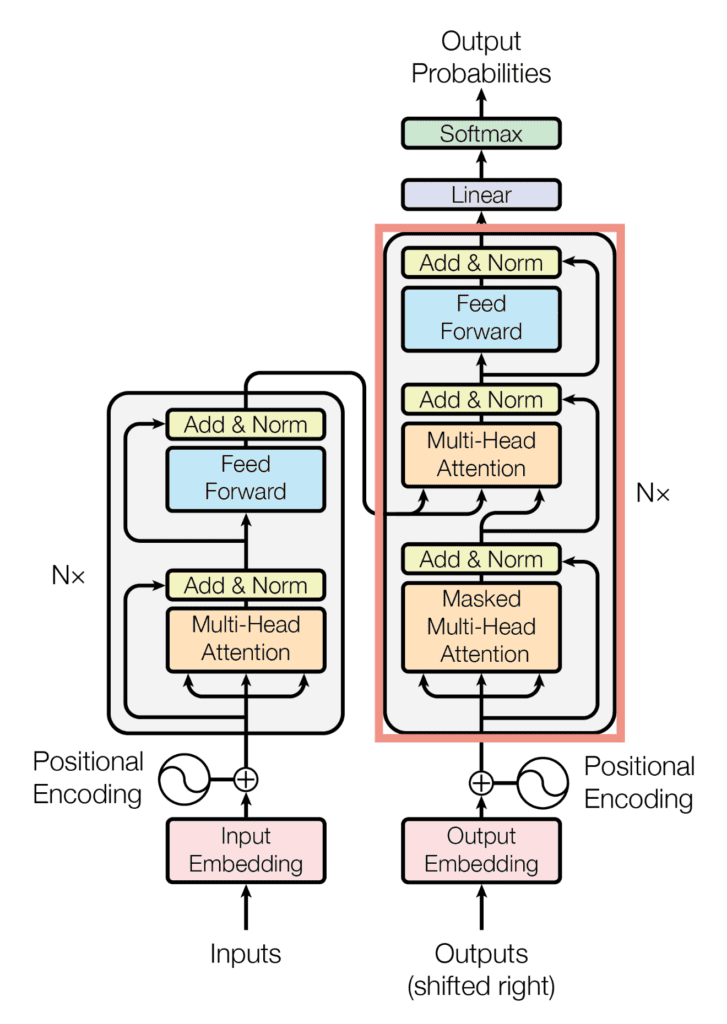

In [60]:
import csv
from gensim.models import Word2Vec
import underthesea #thu vien phan tich tieng viet
import numpy as np
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, LayerNormalization, Dropout
from tensorflow.keras.models import Model
import numpy as np
from transformers import GPT2Tokenizer, GPT2LMHeadModel

from sklearn.model_selection import train_test_split
import re

<p>KHỞI TẠO GIÁ TRỊ VA NƠI LƯU TRỮ</p>

In [61]:
NUM_CLASSES = 8
tokenize = GPT2Tokenizer.from_pretrained('minhtoan/vietnamese-gpt2-finetune')

In [62]:
datase = 'dataset_VN.txt'
w2v_model_path = 'model_tf/w2v_model.hdf5'
model_save_path = 'model_tf/text_classifier.hdf5'
model_json_path = 'model_tf/json'
tflite_save_path = 'model_tf/text_classifier.tflite'
tfjson_save_path = 'model_tf/text_classifier.json'
tfbin_save_path = 'model_tf/text_classifier.bin'
checkpoint_path = "model_tf/text_classifier.ckpt"


<p>NHÚNG VỊ TRÍ CÁC ĐIỂM</p>

In [63]:
def positional_encoding(length, depth):
  depth = depth/2

  positions = np.arange(length)[:, np.newaxis]     # (seq, 1)
  depths = np.arange(depth)[np.newaxis, :]/depth   # (1, depth)

  angle_rates = 1 / (10000**depths)         # (1, depth)
  angle_rads = positions * angle_rates      # (pos, depth)

  pos_encoding = np.concatenate(
      [np.sin(angle_rads), np.cos(angle_rads)],
      axis=-1) 

  return tf.cast(pos_encoding, dtype=tf.float32)

class PositionalEmbedding(tf.keras.layers.Layer):
  def __init__(self, vocab_size, d_model):
    super().__init__()
    self.d_model = d_model
    self.embedding = tf.keras.layers.Embedding(vocab_size, d_model, mask_zero=True) 
    self.pos_encoding = positional_encoding(length=30, depth=d_model)

  def compute_mask(self, *args, **kwargs):
    return self.embedding.compute_mask(*args, **kwargs)

  def call(self, x):
    length = tf.shape(x)[1]
    x = self.embedding(x)
    # This factor sets the relative scale of the embedding and positonal_encoding.
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x = x + self.pos_encoding[tf.newaxis, :length, :]
    return x

<p>TRANSFORMER - TF SOURCE CODE</p>

In [64]:
class FeedForward(tf.keras.layers.Layer):
  def __init__(self, d_model, dff, dropout_rate=0.1):
    super().__init__()
    self.seq = tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),
      tf.keras.layers.Dense(d_model),
      tf.keras.layers.Dropout(dropout_rate)
    ])
    self.add = tf.keras.layers.Add()
    self.layer_norm = tf.keras.layers.LayerNormalization()

  def call(self, x):
    x = self.add([x, self.seq(x)])
    x = self.layer_norm(x) 
    return x
  
class BaseAttention(tf.keras.layers.Layer):
  def __init__(self, **kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
    self.layernorm = tf.keras.layers.LayerNormalization()
    self.add = tf.keras.layers.Add()

class GlobalSelfAttention(BaseAttention):
  def call(self, x):
    attn_output = self.mha(
        query=x,
        value=x,
        key=x)
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x
  
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self,*, d_model, num_heads, dff, dropout_rate=0.1):
    super().__init__()

    self.self_attention = GlobalSelfAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.ffn = FeedForward(d_model, dff)

  def call(self, x):
    x = self.self_attention(x)
    x = self.ffn(x)
    return x

class Encoder(tf.keras.layers.Layer):
  def __init__(self, *, num_layers, d_model, num_heads,
               dff, vocab_size, dropout_rate=0.1):
    super().__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.pos_embedding = PositionalEmbedding(
        vocab_size=vocab_size, d_model=d_model)

    self.enc_layers = [
        EncoderLayer(d_model=d_model,
                     num_heads=num_heads,
                     dff=dff,
                     dropout_rate=dropout_rate)
        for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(dropout_rate)

  def call(self, x):
    # `x` is token-IDs shape: (batch, seq_len)
    x = self.pos_embedding(x)  # Shape `(batch_size, seq_len, d_model)`.

    # Add dropout.
    x = self.dropout(x)

    for i in range(self.num_layers):
      x = self.enc_layers[i](x)

    return x  # Shape `(batch_size, seq_len, d_model)`.

<p>MULTIHEAD ATTENTION</p>

In [65]:
class MultiHeadSelfAttention(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads=8):
        super(MultiHeadSelfAttention, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        assert embed_dim % num_heads == 0
        self.projection_dim = embed_dim // num_heads
        self.query_dense = tf.keras.layers.Dense(embed_dim)
        self.key_dense = tf.keras.layers.Dense(embed_dim)
        self.value_dense = tf.keras.layers.Dense(embed_dim)
        self.combine_heads = tf.keras.layers.Dense(embed_dim)

    def attention(self, query, key, value):
        score = tf.matmul(query, key, transpose_b=True)
        dim_key = tf.cast(tf.shape(key)[-1], tf.float32)
        scaled_score = score / tf.math.sqrt(dim_key)
        weights = tf.nn.softmax(scaled_score, axis=-1)
        output = tf.matmul(weights, value)
        # print(output)
        return output, weights

    def separate_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.projection_dim))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        query = self.query_dense(inputs)  
        key = self.key_dense(inputs)  
        value = self.value_dense(inputs)  
        query = self.separate_heads(query, batch_size)  
        key = self.separate_heads(key, batch_size)  
        value = self.separate_heads(value, batch_size)  
        attention, weights = self.attention(query, key, value)
        attention = tf.transpose(attention, perm=[0, 2, 1, 3])  
        concat_attention = tf.reshape(attention, (batch_size, -1, self.embed_dim))  
        output = self.combine_heads(concat_attention)  
        return output

In [66]:

class EncoderBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(EncoderBlock, self).__init__()
        self.att = MultiHeadSelfAttention(num_heads=num_heads, embed_dim=embed_dim)
        self.ffn = tf.keras.Sequential(
            [Dense(ff_dim, activation="relu"), Dense(embed_dim),]
        )
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)
    
class FinalEncoder(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, num_layers, rate=0.1):
        super(FinalEncoder, self).__init__()
        self.num_layers = num_layers
        self.enc_layers = [
            EncoderBlock(
                        num_heads=num_heads,
                        embed_dim= embed_dim,
                        ff_dim = ff_dim
                        )
            for _ in range(num_layers)]
        self.pos_encoding = positional_encoding(length=30, depth=embed_dim)
        self.d_model = embed_dim
        self.pos_embedding = PositionalEmbedding(
        vocab_size=60000, d_model=embed_dim)
        self.dropout = tf.keras.layers.Dropout(rate)
    
    def call(self, x):
        x = self.pos_embedding(x)
        x = self.dropout(x)
        for i in range(self.num_layers):
            x = self.enc_layers[i](x)
        return x 
        
# class DecoderBlock(tf.keras.layers.Layer):
#     def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
#         super(DecoderBlock, self).__init__()
#         self.att1 = MultiHeadSelfAttention(embed_dim,num_heads)
#         self.att2 = MultiHeadSelfAttention(embed_dim,num_heads)
#         self.ffn = tf.keras.Sequential(
#             [Dense(ff_dim, activation="relu"), Dense(embed_dim),]
#         )
#         self.layernorm1 = LayerNormalization(epsilon=1e-6)
#         self.layernorm2 = LayerNormalization(epsilon=1e-6)
#         self.layernorm3 = LayerNormalization(epsilon=1e-6)
#         self.dropout1 = Dropout(rate)
#         self.dropout2 = Dropout(rate)
#         self.dropout3 = Dropout(rate)

#     def call(self, inputs, encoder_outputs, training):
#         # Self-attention
#         attn1 = self.att1(inputs, inputs, inputs)
#         attn1 = self.dropout1(attn1, training=training)
#         out1 = self.layernorm1(inputs + attn1)
        
#         # Encoder-decoder attention
#         attn2 = self.att2(out1, out1, encoder_outputs)
#         attn2 = self.dropout2(attn2, training=training)
#         out2 = self.layernorm2(out1 + attn2)
        
#         # Feed-forward network
#         ffn_output = self.ffn(out2)
#         ffn_output = self.dropout3(ffn_output, training=training)
#         return self.layernorm3(out2 + ffn_output)

# # Combine encoder and decoder
# class TransformerBlock(tf.keras.Model):
#     def __init__(self, num_layers, embed_dim, num_heads, ff_dim, num_classes, rate=0.1):
#         super(TransformerBlock, self).__init__()
#         self.encoder = [EncoderBlock(embed_dim, num_heads, ff_dim, rate) for _ in range(num_layers)]
#         self.decoder = [DecoderBlock(embed_dim, num_heads, ff_dim, rate) for _ in range(num_layers)]
#         self.global_avg_pooling = tf.keras.layers.GlobalAveragePooling1D()
#         self.dense_64 = tf.keras.layers.Dense(64, activation='relu')
#         self.dropout = tf.keras.layers.Dropout(0.5)
#         self.dense_output = tf.keras.layers.Dense(num_classes, activation='softmax')

#     def call(self, inputs, target, training):
#         enc_output = inputs
#         dec_output = target

#         for encoder in self.encoder:
#             enc_output = encoder(enc_output, training)
        
#         for decoder in self.decoder:
#             dec_output = decoder(dec_output, enc_output, training)
        
#         # Apply additional layers
#         x = self.global_avg_pooling(dec_output)
#         x = self.dense_64(x)
#         x = self.dropout(x, training=training)
#         x = self.dense_output(x)

#         return x


# Define model


In [67]:

model = tf.keras.Sequential([
    # PositionalEmbedding(10,10),
    FinalEncoder(embed_dim=200,num_heads=2,ff_dim=64, num_layers=2, rate = 0.1), #embed dim must = second dim 
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

# input_shape = (42,)  # Shape of each input data
# num_classes = NUM_CLASSES  # Example number of classes
# embed_dim = 10  # Embedding size for each token
# num_heads = 2 # Number of attention heads
# ff_dim = 30  # Hidden layer size in feed forward network inside transformer

# inputs = tf.keras.Input(shape=(1,42))  # Define input shape
4
# attention_output = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)(inputs, inputs)
# attn_output = tf.keras.layers.Dense(embed_dim)(attention_output)
# attn_output = Dropout(0.3)(attn_output, training=True)
# out1 = LayerNormalization(epsilon=1e-6)(inputs + attn_output)
# x = Dense(ff_dim, activation="relu")(out1)
# ffn_output = Dense(embed_dim)(x)
# ffn_output = Dropout(0.3)(ffn_output, training=True)
# x = LayerNormalization(epsilon=1e-6)(out1 + attn_output)
# x = tf.keras.layers.GlobalAveragePooling1D()(x)
# x = Dense(64, activation='relu')(x)
# x = Dropout(0.3)(x)
# outputs = Dense(NUM_CLASSES, activation='softmax')(x)

# model = tf.keras.Model(inputs=inputs, outputs=outputs)

# Compile model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])


<p>TRAINING MODEL</p>

In [68]:
X_dataset = np.loadtxt(datase, delimiter=',', dtype='str', usecols=[1], encoding='utf-8')
y_dataset = np.loadtxt(datase, delimiter=',', dtype='int32', usecols=[0], encoding='utf-8')

word_vectors_3d = np.zeros((len(X_dataset), 30))  # Assuming X_dataset is your dataset
data = []

# Assuming you're using tokenizer like this
# tokenizer.encoder(sentence.lower())

for i, sentence in enumerate(X_dataset):
    clean_data = re.sub(r'[^\w\s]', '', sentence).lower().strip()
    # tokens = clean_data.lower().split()
    tokens = tokenize.encode(clean_data)
    # Padding each token list to have 30 elements
    tokens += [0] * (30 - len(tokens))
    word_vectors_3d[i] = tokens
    # Get unique vocabulary
    # vocabulary = list(set(tokens))
    # word_vector = []
    # # for word in vocabulary:
    # #     # Append word vectors to the list
    # #     word_vector.append(w2v_model.wv[word].tolist())
    # # Pad the word vectors with zeros if the length is less than 8
    # word_vector += [[0] * 100] * (30 - len(word_vector))
    # word_vectors = np.array(word_vector).reshape(30, 100)
    
    # Assign word vectors to the 3D array
    # word_vectors_3d[i] = word_vectors
X_train, X_test, y_train, y_test = train_test_split(word_vectors_3d, y_dataset, train_size=0.75, random_state=42)
# print(X_train)
# X_train = np.reshape(X_train, (-1, 1,42))
# X_test = np.reshape(X_test, (-1, 1,42))
# y_train = np.expand_dims(X_train, axis=1) 
# y_test = np.expand_dims(X_train, axis=1) 
# cp_callback = tf.keras.callbacks.ModelCheckpoint(
# checkpoint_path, verbose=1, save_weights_only=False)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)
# Train model
history = model.fit(X_train, y_train
            , batch_size=128, epochs=2000, validation_data=(X_test, y_test), callbacks=[es_callback])

# Evaluate model
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Accuracy:", accuracy)

Epoch 1/2000
12/12 [==============================] - 10s 391ms/step - loss: 2.1271 - accuracy: 0.2205 - val_loss: 2.0096 - val_accuracy: 0.2638
Epoch 2/2000
12/12 [==============================] - 4s 301ms/step - loss: 2.0060 - accuracy: 0.2539 - val_loss: 1.9623 - val_accuracy: 0.3252
Epoch 3/2000
12/12 [==============================] - 4s 297ms/step - loss: 1.9494 - accuracy: 0.2621 - val_loss: 1.8929 - val_accuracy: 0.3006
Epoch 4/2000
12/12 [==============================] - 4s 296ms/step - loss: 1.8863 - accuracy: 0.2949 - val_loss: 1.8352 - val_accuracy: 0.3190
Epoch 5/2000
12/12 [==============================] - 4s 306ms/step - loss: 1.8236 - accuracy: 0.3181 - val_loss: 1.7690 - val_accuracy: 0.3333
Epoch 6/2000
12/12 [==============================] - 4s 296ms/step - loss: 1.7385 - accuracy: 0.3536 - val_loss: 1.6736 - val_accuracy: 0.3722
Epoch 7/2000
12/12 [==============================] - 4s 296ms/step - loss: 1.6695 - accuracy: 0.3700 - val_loss: 1.5767 - val_accuracy

In [69]:
model.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 final_encoder_5 (FinalEnco  (None, 30, 200)           12374928  
 der)                                                            
                                                                 
 flatten_5 (Flatten)         (None, 6000)              0         


                                                                 
 dense_82 (Dense)            (None, 32)                192032    
                                                                 
 dropout_35 (Dropout)        (None, 32)                0         
                                                                 
 dense_83 (Dense)            (None, 8)                 264       
                                                                 
Total params: 12567224 (47.94 MB)
Trainable params: 12567224 (47.94 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


<p>CONFUSSION MATRIX</p>

16/16 [==============================] - 1s 9ms/step


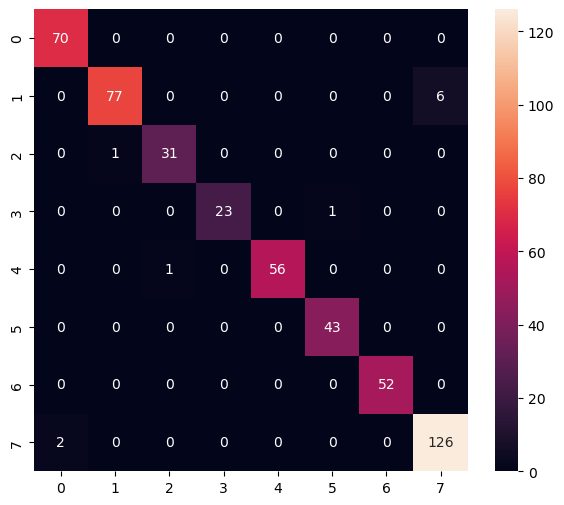

Classification Report
              precision    recall  f1-score   support

           0       0.97      1.00      0.99        70
           1       0.99      0.93      0.96        83
           2       0.97      0.97      0.97        32
           3       1.00      0.96      0.98        24
           4       1.00      0.98      0.99        57
           5       0.98      1.00      0.99        43
           6       1.00      1.00      1.00        52
           7       0.95      0.98      0.97       128

    accuracy                           0.98       489
   macro avg       0.98      0.98      0.98       489
weighted avg       0.98      0.98      0.98       489



In [70]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

<p>TRAINING LOSS AFTER EPOCH</p>

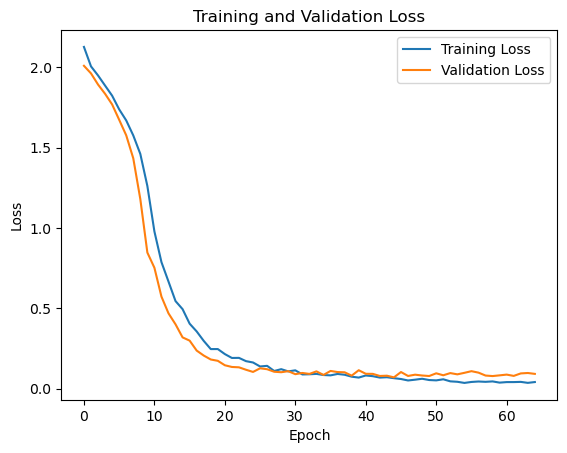

In [71]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

<p>SAVE MODEL</p>

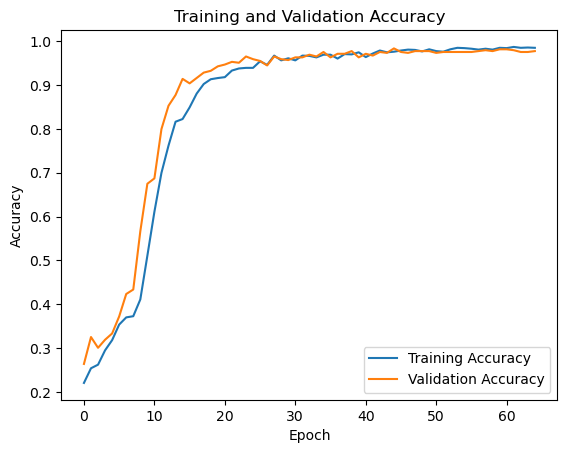

In [72]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

In [73]:
model.save(model_save_path)

C:\Users\MSI\AppData\Roaming\Python\Python310\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [74]:

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)
# model_config = model.get_config()
# import json
# # Serialize dictionary to JSON
# model_json = json.dumps(model_config)

# Save JSON to a file
# with open(tfjson_save_path, 'w') as json_file:
#     json_file.write(model_json)

# with open(tfbin_save_path, 'wb') as f:
#     for layer in model.layers:
#         for weight in layer.get_weights():
#             np.array(weight).tofile(f)


INFO:tensorflow:Assets written to: C:\Users\MSI\AppData\Local\Temp\tmphg4218lp\assets


INFO:tensorflow:Assets written to: C:\Users\MSI\AppData\Local\Temp\tmphg4218lp\assets


12654192

<p>TEST</p>

In [75]:
test_data = "Đèn 1 sáng lên"
input_ids = tokenizer.encode(test_data.lower())
print(input_ids)
# padded_tokens = np.pad(input_ids, (0, max(0, 30 - len(input_ids))), mode='constant', constant_values=np.random.randint(0, 9194, 1))
# print([0]*30)
input_ids += [0] * (30 - len(input_ids))
word_vector = np.array(input_ids).reshape(30,)
print(np.argmax(model(np.array([word_vector],dtype=np.float32))))

NameError: name 'tokenizer' is not defined

In [ ]:
test_data = "Off All"
clean_data = re.sub(r'[^\w\s]', '', test_data)
test_token = clean_data.lower().split()
vocabulary = list(set(test_token))
word_vector_test = []
# Iterate through each word in the vocabulary
for word in vocabulary:
    # Append word vectors to the list
    word_vector_test.append(w2v_model.wv[word].tolist())
# Pad the word vectors with zeros if the length is less than 8
word_vector_test += [[0] * 100] * (30 - len(word_vector_test))
word_vectors = np.array(word_vector_test).reshape(30, 100)
print(np.argmax(model(np.array([word_vectors],dtype=np.float32))))

NameError: name 'w2v_model' is not defined

In [ ]:
test_data = "Led 2 on"
clean_data = re.sub(r'[^\w\s]', '', test_data)
test_token = clean_data.lower().split()
vocabulary = list(set(test_token))
word_vector_test = []
# Iterate through each word in the vocabulary
for word in vocabulary:
    # Append word vectors to the list
    word_vector_test.append(w2v_model.wv[word].tolist())
# Pad the word vectors with zeros if the length is less than 8
word_vector_test += [[0] * 100] * (30 - len(word_vector_test))
word_vectors = np.array(word_vector_test).reshape(30, 100)
print(np.argmax(model(np.array([word_vectors],dtype=np.float32))))

2


In [ ]:
test_data = "Led một và hai on"
clean_data = re.sub(r'[^\w\s]', '', test_data)
test_token = clean_data.lower().split()
vocabulary = list(set(test_token))
word_vector_test = []
# Iterate through each word in the vocabulary
for word in vocabulary:
    # Append word vectors to the list
    word_vector_test.append(w2v_model.wv[word].tolist())
# Pad the word vectors with zeros if the length is less than 8
word_vector_test += [[0] * 100] * (30 - len(word_vector_test))
word_vectors = np.array(word_vector_test).reshape(30, 100)
print(np.argmax(model(np.array([word_vectors],dtype=np.float32))))

4


In [ ]:
test_data = "First and third led go on"
clean_data = re.sub(r'[^\w\s]', '', test_data)
test_token = clean_data.lower().split()
vocabulary = list(set(test_token))
word_vector_test = []
# Iterate through each word in the vocabulary
for word in vocabulary:
    # Append word vectors to the list
    word_vector_test.append(w2v_model.wv[word].tolist())
# Pad the word vectors with zeros if the length is less than 8
word_vector_test += [[0] * 100] * (30 - len(word_vector_test))
word_vectors = np.array(word_vector_test).reshape(30, 100)
print(np.argmax(model(np.array([word_vectors],dtype=np.float32))))

5


In [ ]:
test_data = "go on đèn 2 và 3"
clean_data = re.sub(r'[^\w\s]', '', test_data)
test_token = clean_data.lower().split()
vocabulary = list(set(test_token))
word_vector_test = []
# Iterate through each word in the vocabulary
for word in vocabulary:
    # Append word vectors to the list
    word_vector_test.append(w2v_model.wv[word].tolist())
# Pad the word vectors with zeros if the length is less than 8
word_vector_test += [[0] * 100] * (30 - len(word_vector_test))
word_vectors = np.array(word_vector_test).reshape(30, 100)
print(np.argmax(model(np.array([word_vectors],dtype=np.float32))))

6


In [ ]:
test_data = "All Led On"
clean_data = re.sub(r'[^\w\s]', '', test_data)
test_token = clean_data.lower().split()
vocabulary = list(set(test_token))
word_vector_test = []
# Iterate through each word in the vocabulary
for word in vocabulary:
    # Append word vectors to the list
    word_vector_test.append(w2v_model.wv[word].tolist())
# Pad the word vectors with zeros if the length is less than 8
word_vector_test += [[0] * 100] * (30 - len(word_vector_test))
word_vectors = np.array(word_vector_test).reshape(30, 100)
print(np.argmax(model(np.array([word_vectors],dtype=np.float32))))

7
